<a href="https://colab.research.google.com/github/dnevo/Titanic/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# following lines are specific to Google Colab
#%load_ext google.colab.data_table
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Titanic'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Titanic


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df_train = pd.read_csv('datasets/train.csv',index_col=0)
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C


In [7]:
df_test = pd.read_csv('datasets/test.csv',index_col=0)
df_test.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S


### Combine Test and Validation for easier pre-processing

In [0]:
df_combined = pd.concat([df_train,df_test])

In [0]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


As above, there are few columns with missing values:
- `Age`: 263 missing values. Must be handled as it may have big impact on survival
- `Fare`: 1 missing value
- `Cabin`: mostly missing values - we will drop it.
- `Embarked`: 2 missing values

#### Extract the title from the `Name` column - this is the part which can have meaning

In [0]:
title = df_combined.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Mme               1
Jonkheer          1
Lady              1
Capt              1
the Countess      1
Don               1
Sir               1
Dona              1
Name: Name, dtype: int64

As above, 4 titles are the most frequent ones - we will later convert the other titles to these 4. Mr: adult male, Miss: young female, Mrs: adult female, Master: child male

In [0]:
title_dict = {'Mr':'Mr',  'Mrs':'Mrs',  'Miss':'Miss',  'Master':'Master',  'Don':'Mr',  'Rev':'Mr',  'Dr':'Mr','Mme':'Mrs', 'Ms':'Miss', 
              'Major':'Mr', 'Lady':'Mrs', 'Sir':'Mr', 'Mlle':'Miss', 'Col':'Mr', 'Capt':'Mr', 'the Countess':'Mrs', 'Jonkheer':'Mr', 'Dona':'Mrs'}
df_combined['Title'] = title.map(title_dict)

Handling missing values in `Age`. As can be noticed, `Age` has correlation to `Pclass` (higher ages in Pclass=1), and to `title` (Mrs > Mr > Miss > Master)

In [0]:
df_combined.groupby(['Title','Pclass'])['Age'].mean()

Title   Pclass
Master  1               6.98
        2               2.76
        3               6.09
Miss    1              30.13
        2              20.87
        3              17.36
Mr      1              42.24
        2              32.91
        3              28.32
Mrs     1              42.80
        2              33.52
        3              32.33
Name: Age, dtype: float64

In [0]:
df_combined['Age'] = df_combined['Age'].fillna(df_combined.groupby(['Title', 'Pclass'])['Age'].transform('mean'))

Handling missing values in `Embarked`:

In [0]:
print(df_combined['Embarked'].value_counts())
df_combined.Embarked.fillna(value='S',inplace=True) # replace by 'S' since it is the most frequent

S    914
C    270
Q    123
Name: Embarked, dtype: int64


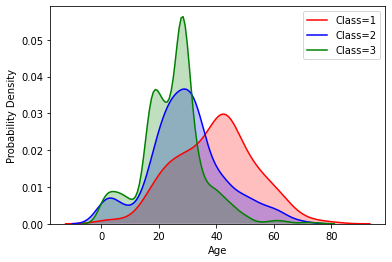

In [0]:
sns.kdeplot(df_combined.loc[(df_combined['Pclass']==1), 'Age'], color='r', shade=True, Label='Class=1')  
sns.kdeplot(df_combined.loc[(df_combined['Pclass']==2), 'Age'], color='b', shade=True, Label='Class=2') 
sns.kdeplot(df_combined.loc[(df_combined['Pclass']==3), 'Age'], color='g', shade=True, Label='Class=3') 
plt.xlabel('Age');
plt.ylabel('Probability Density');

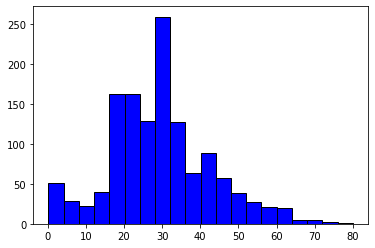

In [0]:
plt.hist(df_combined['Age'], color = 'blue', edgecolor = 'black', bins = int(20));

In [0]:
df_combined['age_group'] = pd.cut(df_combined['Age'], bins=[i for i in range(0,81,5)], right=False) #,labels=[i for i in range(1,81,5)])
df_combined[df_combined['Sex']=='male'].groupby('age_group').agg({'Survived': ['count', 'sum', 'mean']}).head(5)

Survived                        
             count         sum        mean
age_group                                 
[0, 5)          23       15.00        0.65
[5, 10)         13        6.00        0.46
[10, 15)         7        2.00        0.29
[15, 20)        50        5.00        0.10
[20, 25)        72        7.00        0.10

Following above, create new `is_child` feature, since survival rate below 10 is higher.

In [0]:
df_combined['is_child'] = np.where(df_combined['Age'] < 10, 1, 0)

create `family_size` - as can be seen, high correlation to survival rate:

In [0]:
df_combined['family_size'] = df_combined.SibSp + df_combined.Parch
df_combined[df_combined['Sex']=='male'].groupby('family_size').agg({'Survived': ['count', 'sum', 'mean']})

Survived                        
               count         sum        mean
family_size                                 
0                411       64.00        0.16
1                 74       18.00        0.24
2                 53       21.00        0.40
3                 10        5.00        0.50
4                  3        0.00        0.00
5                 14        0.00        0.00
6                  4        1.00        0.25
7                  4        0.00        0.00
10                 4        0.00        0.00

In [0]:
df_combined.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age_group,is_child,family_size
count,891.00,"1,309.00",1309,1309,"1,309.00","1,309.00","1,309.00",1309,"1,308.00",295,1309,1309,1308,"1,309.00","1,309.00"
unique,nan,nan,1307,2,nan,nan,nan,929,nan,186,3,4,16,nan,nan
top,nan,nan,"Connolly, Miss. Kate",male,nan,nan,nan,CA. 2343,nan,C23 C25 C27,S,Mr,"[25, 30)",nan,nan
freq,nan,nan,2,843,nan,nan,nan,11,nan,6,916,783,296,nan,nan
mean,0.38,2.29,NaN,NaN,29.53,0.50,0.39,NaN,33.30,NaN,NaN,NaN,NaN,0.07,0.88
std,0.49,0.84,NaN,NaN,13.42,1.04,0.87,NaN,51.76,NaN,NaN,NaN,NaN,0.25,1.58
min,0.00,1.00,NaN,NaN,0.17,0.00,0.00,NaN,0.00,NaN,NaN,NaN,NaN,0.00,0.00
25%,0.00,2.00,NaN,NaN,21.00,0.00,0.00,NaN,7.90,NaN,NaN,NaN,NaN,0.00,0.00
50%,0.00,3.00,NaN,NaN,28.32,0.00,0.00,NaN,14.45,NaN,NaN,NaN,NaN,0.00,0.00
75%,1.00,3.00,NaN,NaN,36.50,1.00,0.00,NaN,31.27,NaN,NaN,NaN,NaN,0.00,1.00


In [0]:
df_combined.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Fare','Cabin', 'Title', 'Age', 'age_group'],inplace=True)


In [0]:
df_combined.head()

,Survived,Pclass,Sex,Embarked,is_child,family_size
PassengerId,,,,,,
1,0.00,3,male,S,0,1
2,1.00,1,female,C,0,1
3,1.00,3,female,S,0,0
4,1.00,1,female,S,0,1
5,0.00,3,male,S,0,0


# Regression Models (One Hot Encoding)

### Decompose into Test and Train

In [0]:
combined = pd.get_dummies(df_combined, columns=['Pclass','Sex', 'Embarked', 'family_size'], drop_first=True)

In [0]:
combined.head()

,Survived,is_child,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_10
PassengerId,,,,,,,,,,,,,,,
1,0.00,0,0,1,1,0,1,1,0,0,0,0,0,0,0
2,1.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1.00,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,1.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0
5,0.00,0,0,1,1,0,1,0,0,0,0,0,0,0,0


In [0]:
train = combined[:df_train.shape[0]].copy()
test = combined[df_train.shape[0]:].copy()
test.drop('Survived',axis=1,inplace=True)

encode `Sex` to `is_male`
encode `Pclass`
encode embarked

Train set split
test model LR
check metrics - train, valid and test
repeat for decision - including validation curve
repeat for random forest - including validation curve

In [0]:
def split_data(df_train):
  _df_train, df_temp = train_test_split(df_train, test_size=0.4, random_state=12345)
  df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345)
  features_train = _df_train.drop(['Survived'], axis=1)
  target_train = _df_train['Survived']
  features_valid = df_valid.drop(['Survived'], axis=1)
  target_valid = df_valid['Survived']
  features_test = df_test.drop(['Survived'], axis=1)
  target_test = df_test['Survived']
  return features_train, target_train, features_valid, target_valid, features_test, target_test

In [0]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_data(train)

In [0]:
features_train.describe(include='all')

,is_child,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_10
count,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00,534.00
mean,0.09,0.21,0.57,0.65,0.09,0.74,0.18,0.12,0.04,0.02,0.03,0.01,0.01,0.01
std,0.28,0.40,0.50,0.48,0.29,0.44,0.39,0.32,0.19,0.13,0.18,0.12,0.10,0.11
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [0]:
model = LogisticRegression(random_state=12345, class_weight=None)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print("score:", model.score(target_valid, predictions_valid))

F1: 0.6724137931034482


In [0]:
def learning_curve(train, valid, steps, target):
    plt.figure(figsize=(9, 9))
    targets = [target]* len(train)
    plt.plot(steps, train, 'o-', color="r", label="Training")
    plt.plot(steps, valid, 'o-', color="b", label="Validation")
    plt.plot(steps, targets,'-', color="g", label="Target")
    plt.ylabel('Score') 
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

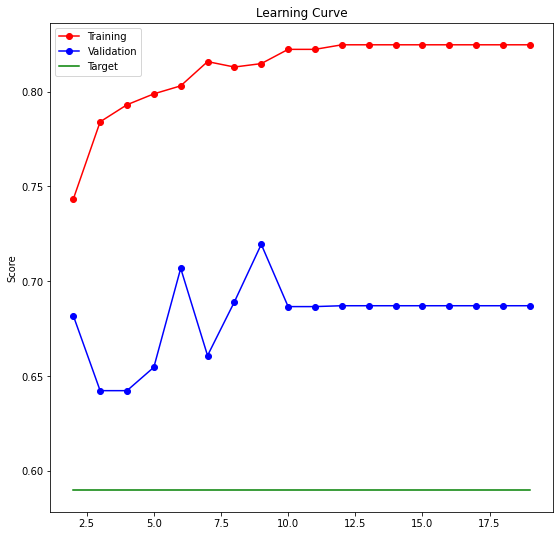

In [0]:
score_train = []
score_valid = []
steps = []
for depth in range(2,20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    steps.append(depth)
    score_train.append(model.score(target_train, model.predict(features_train)))
    score_valid.append(model.score(target_valid, model.predict(features_valid)))
learning_curve(score_train, score_valid, steps, 0.59)

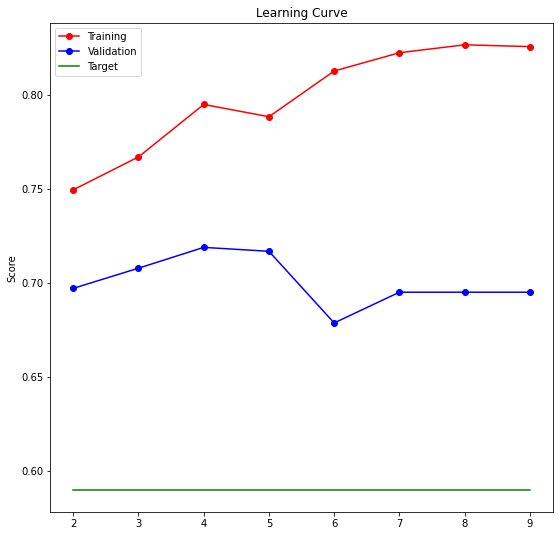

In [0]:
score_train = []
score_valid = []
steps = []
for depth in range(2,10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    steps.append(depth)
    score_train.append(model.score(target_train, model.predict(features_train)))
    score_valid.append(model.score(target_valid, model.predict(features_valid)))

learning_curve(score_train, score_valid, steps, 0.59)

In [0]:
model = RandomForestClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
print(
    model.score(target_train, model.predict(features_train)),
    model.score(target_valid, model.predict(features_valid)),
    model.score(target_test, model.predict(features_test))
    )

0.7882037533512064 0.7166666666666666 0.7586206896551725


# Tree based models Models - Ordinal Encoding

In [0]:
encoder = OrdinalEncoder()
combined['Embarked'] = encoder.fit_transform(combined[['Embarked']])
combined = pd.get_dummies(combined, columns=['Sex'], drop_first=True)